# Implementation of Variational AutoEncoder (VAE)

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import pickle
from torch.utils.data import TensorDataset,random_split,DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 50

x_dim  = 21
hidden_dim = 20
latent_dim = 15

lr = 1e-3

epochs = 5

In [3]:
torch.__version__

'2.1.2+cu118'

In [4]:
capped=13600
with open("hist_data_2018-1-1_2023-7-12_trainX_trainY.pkl","rb") as f:
    [training_X,training_Y,correlation_Y] = pickle.load(f)

In [5]:
[training_X,training_Y,correlation_Y] = [training_X[:capped],training_Y[:capped],correlation_Y[:capped]] 

In [6]:
training_X.shape,training_Y.shape,correlation_Y.shape

((13600, 21), (13600,), (13600,))

###    Step 1. Load (or download) Dataset

In [7]:
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

In [8]:
training_X.reshape(-1,1,3,7).shape

(13600, 1, 3, 7)

In [9]:
inputs = torch.tensor(training_X.reshape(-1,1,3,7), dtype=torch.float32)
targets = torch.tensor(training_Y.reshape(-1,1), dtype=torch.float32)

In [10]:
type(inputs)

torch.Tensor

In [11]:

ds = TensorDataset(inputs,targets)#
train_ds,val_ds = random_split(ds, (0.5,0.5)) #torch.utils.data

In [12]:
type(ds)

torch.utils.data.dataset.TensorDataset

In [13]:
kwargs = {'num_workers': 1, 'pin_memory': True} 
train_loader = DataLoader(dataset=train_ds, batch_size = batch_size, shuffle=True, **kwargs) #torch.utils.data
test_loader = DataLoader(dataset=val_ds, batch_size =batch_size, shuffle=False, **kwargs)

In [14]:
len(train_loader),len(test_loader),len(train_ds)

(136, 136, 6800)

In [15]:
# %%time
# train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
# test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [16]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [17]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [18]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [19]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [20]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    # print("x_hat",len(x_hat),len(x))
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [21]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [22]:
%%time
print("Start training VAE...")
model.train()
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x,_) in enumerate(train_loader): 
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", f"{overall_loss / (batch_idx*batch_size):.2f}")
    
print("Finish!!")

Start training VAE...


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Step 5. Generate images from test dataset

In [23]:
import matplotlib.pyplot as plt

In [24]:
%%time
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|                                                                                                                                                          | 0/136 [00:08<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [25]:
def show_image(x, idx):
    x = x.view(batch_size, 3, 7)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

In [26]:
def show_image_ax(x, idx,ax):
    x = x.view(batch_size, 3, 7) 
    ax.imshow(x[idx].cpu().numpy())

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


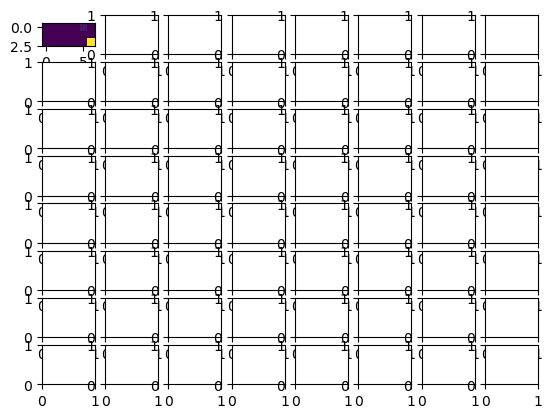

In [27]:
%%time
fig,axx = plt.subplots(8,8)
axx=axx.ravel()
for idx,(ax1,ax2) in enumerate( zip(axx[::2],axx[1::2])):
    show_image_ax(x, idx,ax1)
    show_image_ax(x_hat, idx,ax2)

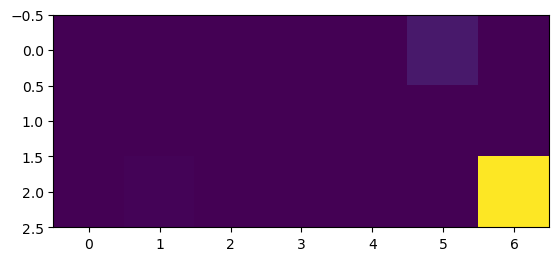

In [28]:
show_image(x, idx=0)

In [29]:
show_image(x_hat, idx=0)

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


<Figure size 640x480 with 0 Axes>

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [ ]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [ ]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

In [ ]:
show_image(generated_images, idx=12)

In [ ]:
show_image(generated_images, idx=0)

In [ ]:
show_image(generated_images, idx=1)

In [ ]:
show_image(generated_images, idx=10)

In [ ]:
show_image(generated_images, idx=20)

In [ ]:
show_image(generated_images, idx=50)